In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense
from tensorflow.keras.layers import Activation, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

import tensorflow_model_optimization as tfmot

## Load and preprocess training and testing dataset

In [2]:
data= pd.read_csv("res.csv") 

In [3]:
data.head()

,one,two,three,four,five,six,seven,eight,cls
0,33,20,53,95,70,48,22,34,0
1,30,28,70,96,74,49,26,37,0
2,39,27,71,96,77,55,25,37,0
3,38,25,73,96,75,54,24,36,0
4,36,26,57,95,75,55,19,31,0


In [4]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=10)

In [5]:
train_data = train_data.reset_index(drop=True)
train_features = train_data.copy()
train_labels = train_features.pop("cls")
test_data = test_data.reset_index(drop=True)
test_features = test_data.copy()
test_labels = test_features.pop("cls")

In [6]:
train_features

,one,two,three,four,five,six,seven,eight
0,37,2,30,77,184,63,37,38
1,13,0,92,84,25,27,2,35
2,23,1,52,87,196,37,0,41
3,29,0,45,94,197,43,0,42
4,38,25,70,95,76,55,25,36
...,...,...,...,...,...,...,...,...
475,31,13,64,93,28,22,2,38
476,19,10,63,93,27,12,0,35
477,40,3,53,98,197,40,3,40
478,38,0,41,139,114,42,1,37


## Load and process training and testing dataset

In [7]:
# Transfer to nparray
num_classes = 6
train_features = train_features.values.astype("float32")
train_labels_one_hot = to_categorical(train_labels, num_classes, dtype="float32")
test_features = test_features.values.astype("float32")
test_labels_one_hot = to_categorical(test_labels, num_classes, dtype="float32")

In [8]:
def normalize(x):
    # Normalize the value first
    max_num = np.amax(x)
    x = x / max_num
    x = (x * 255) - 128
    
    return x

In [9]:
# Normalize the features
train_features = normalize(train_features)
test_features = normalize(test_features)

In [10]:
print(train_features)

[[ -90.259995 -125.96      -97.4      ...  -63.739998  -90.259995
   -89.240005]
 [-114.74     -128.        -34.159996 ... -100.46     -125.96
   -92.3     ]
 [-104.54     -126.98      -74.96     ...  -90.259995 -128.
   -86.18    ]
 ...
 [ -87.2      -124.94      -73.94     ...  -87.2      -124.94
   -87.2     ]
 [ -89.240005 -128.        -86.18     ...  -85.16     -126.98
   -90.259995]
 [ -82.1      -128.        -97.4      ...  -62.719994  -92.3
   -91.28    ]]


## Model define and create

In [11]:
model = Sequential()

# FC1
model.add(Input(shape=(8,), dtype=tf.float32))
model.add(Dense(64, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))

# FC2
model.add(Dense(128, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))

# FC3
model.add(Dense(6))

In [12]:
model = tfmot.quantization.keras.quantize_model(model)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 8)                3         
 er)                                                             
                                                                 
 quant_dense (QuantizeWrappe  (None, 64)               515       
 rV2)                                                            
                                                                 
 quant_batch_normalization (  (None, 64)               259       
 QuantizeWrapperV2)                                              
                                                                 
 quant_activation (QuantizeW  (None, 64)               3         
 rapperV2)                                                       
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 128)              8

## Model training

In [13]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [14]:
# Training model

# Define optimizer loss function and merics 
model.compile(
    optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

# Set training
history = model.fit(
    train_features, train_labels_one_hot, 
    validation_data=(test_features, test_labels_one_hot), batch_size=64,
    verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 24ms/step - loss: 1.4157 - accuracy: 0.4521 - val_loss: 3.3593 - val_accuracy: 0.1583
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 0.4191 - accuracy: 0.9500 - val_loss: 4.2289 - val_accuracy: 0.1583
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 0.1965 - accuracy: 0.9812 - val_loss: 4.1479 - val_accuracy: 0.1750
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1124 - accuracy: 0.9875 - val_loss: 3.7760 - val_accuracy: 0.1833
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0924 - accuracy: 0.9875 - val_loss: 3.4584 - val_accuracy: 0.2167
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0673 - accuracy: 0.9937 - val_loss: 3.0899 - val_accuracy: 0.3333
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0639 - accuracy: 0.9937 - val_loss: 2.6784 - val_accuracy: 0.4000
Epoch 8/100
8/8 [=========

8/8 [==============================] - 0s 3ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 60/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 61/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 62/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 63/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 64/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 65/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 66/100
8/8 [===============

In [15]:
model.evaluate(test_features, test_labels_one_hot)

4/4 [==============================] - 0s 995us/step - loss: 0.0012 - accuracy: 1.0000


[0.001241261255927384, 1.0]

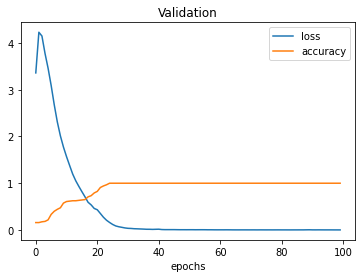

In [16]:
plt.title("Validation")
plt.plot(history.history["val_loss"], label="loss")
plt.plot(history.history["val_accuracy"], label="accuracy")
plt.xlabel("epochs")
plt.legend()
plt.savefig("valid.pdf")

#Save weights of this model  
model.save_weights('my_model.h5')

#load weights to this TensorFlow model  
model.load_weights('my_model.h5')

In [17]:
# Save model and weights of this model
model.save("model_save")

INFO:tensorflow:Assets written to: model_save\assets


INFO:tensorflow:Assets written to: model_save\assets


## Reload and preprocess images in TFLM

## Convert model into TFLM format

In [18]:
max_samples = len(test_features)

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

In [20]:
test_features = tf.cast(test_features, tf.float32)
tf_lite_ds = tf.data.Dataset.from_tensor_slices((test_features)).batch(1)

def representative_data_gen():
    for input_value in tf_lite_ds.take(len(tf_lite_ds)):
        yield [input_value]
    
converter.representative_dataset = representative_data_gen

In [21]:
import pathlib

converter_model = converter.convert()

generated_dir = pathlib.Path("generated/")
generated_dir.mkdir(exist_ok=True, parents=True)
converted_model_file = generated_dir/"pose.tflite"
converted_model_file.write_bytes(converter_model)

INFO:tensorflow:Assets written to: C:\Users\William\AppData\Local\Temp\tmp_bvlcs0b\assets


INFO:tensorflow:Assets written to: C:\Users\William\AppData\Local\Temp\tmp_bvlcs0b\assets
C:\Users\William\anaconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


13760

In order to integrate converted model into TFLM application we have to save it as a C array. One way to do that is to use **xxd** utility available on Linux or in Cygwin/MinGW terminals on Windows. Open terminal and run following commands:

```
cd generated/
xxd -i emnist_model_int8.tflite > model.h
```

The model is ready to be integrated into TFLM application.

## Evaluate TensorFlow Lite Model

In [22]:
import pathlib

generated_dir = pathlib.Path("generated/")
generated_dir.mkdir(exist_ok=True, parents=True)
converted_model_file = generated_dir/"pose.tflite"

interpreter = tf.lite.Interpreter(model_path=str(converted_model_file))
interpreter.allocate_tensors()

# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    scale, zero_point = interpreter.get_output_details()[0]["quantization"]

    prediction_values = []
    
    for test_data in test_features:
        # Pre-processing: add batch dimension, quantize and convert inputs to int8 to match with
        # the model's input data format.
        test_data = np.expand_dims(test_data, axis=0)
        test_data = np.int8(test_data)
        interpreter.set_tensor(input_index, test_data)

        interpreter.invoke()

        # Find the letter with highest probability
        output = interpreter.tensor(output_index)
        result = np.argmax(output()[0])
        prediction_values.append(result)
    
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == test_labels[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy * 100

Please, keep in mind that full test dataset evaluation on int8 model may take several minutes. 

In [23]:
print(str(evaluate_model(interpreter)) + "%")

100.0%


## Create a test set for target application

In [24]:
import random

# Import training and testing from dataset_buffer
num_of_samples = 25
random_test_features = random.sample(range(1, test_features.shape[0]), num_of_samples)

In [25]:
samples_file = open("generated/test_samples.cpp", "w")

samples_file.write("#include \"test_samples.h\"\n\n")
samples_file.write("const int kNumSamples = " + str(num_of_samples) + ";\n\n")

samples = "" 
samples_array = "const TestSample test_samples[kNumSamples] = {"

for sample_idx, feature_idx in enumerate(random_test_features, 1):
    feature_arr = list(np.array(test_features[feature_idx]).astype("int"))
    var_name = "sample" + str(sample_idx)
    samples += "TestSample " + var_name + " = {\n" #+ "[IMAGE_SIZE] = { "
    samples += "\t.label = " + str(test_labels[feature_idx]) + ",\n" 
    samples += "\t.feature = {\n"
    samples += "\t\t" + str(feature_arr)
    samples += "\t}\n};\n\n"    
    samples_array += var_name + ", "
    
samples = samples.replace("[", "")
samples = samples.replace("]", ",\n")
samples_array += "};\n"

samples_file.write(samples);
samples_file.write(samples_array);
samples_file.close()